#

# Peer-induced fairness framework for algorithmic bias auditing

###

* Example: sensitive attribute = firm's size, we treat micro-firms as protected group and non-micro firms as non-protected group
* Data: we collect data from UK Archive Small and Medium-Sized Enterprise Finance Monitor https://doi.org/10.5255/UKDA-SN-6888-26
* Peer identification threshold in this file is $0.3 \times Std_{IC}$, fitting model: logistic, prediction model: random forest

#

## (1) Data Preprocessing

In [7]:
import sys
sys.path.append("../..")
from preprocessing import data_preprocess

import numpy as np
import pandas as pd


%load_ext autoreload
%autoreload 2

In [10]:
import pandas as pd

# Paths to the tab data files
data_paths = [
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q4_2012-q1_2015_data.tab',
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q3_2015_q4_2017.tab',
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q1_2018-q2_2020.tab'
]

# Combine the dataframes
df_list = [pd.read_csv(path, sep='\t') for path in data_paths]  # Assuming tab-separated values
df_count = pd.concat(df_list, ignore_index=True)

# Get the total number of entries
total_entries = df_count.shape[0]
print(f"The total number of entries in the combined dataset is: {total_entries}")

C:\Users\s2285280\AppData\Local\Temp\ipykernel_24860\4124027893.py:11: DtypeWarning: Columns (13,41,42,49,52,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,1907,1908,1911,1912,1913,1914,1933,1938,1939,1940,1941,1942,1943,1944,1945,1946,1963,2002,2003,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2148,2149,2150,2151,2152,2153,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2210,2215,2216,2217,2218,2219,2220,2225,2227) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(path, sep='\t') for path in data_paths]  # Assuming tab-separated values


The total number of entries in the combined dataset is: 141166


In [14]:
# Step1: Combine dataframe
# ..represent the previous layer
df_combined = data_preprocess.combine_data(['../../../datasets/SMEs_F/raw/sme_finance_monitor_q4_2012-q1_2015_data.tab',
                                            '../../../datasets/SMEs_F/raw/sme_finance_monitor_q3_2015_q4_2017.tab',
                                            '../../../datasets/SMEs_F/raw/sme_finance_monitor_q1_2018-q2_2020.tab'],
                                            ['../../../datasets/SMEs_F/selection/selectedfeatures1.csv',
                                             '../../../datasets/SMEs_F/selection/selectedfeatures2.csv',
                                             '../../../datasets/SMEs_F/selection/selectedfeatures3.csv'],
                                             '../../../datasets/SMEs_F/selection/common_featuresname.csv')

In [15]:
# Step 2: Replace DK/Refused data
df_replace_dk_refused = data_preprocess.replace_dk_refused(df_combined)
# Step 3: Replace missing values in the combined data
replacena_df = data_preprocess.replace_missing_values(df_replace_dk_refused)
# Step 4: Check column-wise missing ratio and select columns with ratio <= 0.5
del_hmc_df, NAN_ratios, keep_columns = data_preprocess.check_col_missing_ratio(replacena_df, 0.5)
# Step 5: Check row-wise missing ratio and select rows with ratio < 0.2
del_hmr_df = data_preprocess.check_row_missing_ratio(del_hmc_df, 0.2)
# Step 6: Impute missing data in the selected columns
fill_df = data_preprocess.impute_missing_data(del_hmr_df)
# Step 7: Convert data to integer type
int_df = data_preprocess.convert_to_int(fill_df)
# Step 8: Remove NAN Final Outcomes
delfona_df = data_preprocess.remove_nan_final_outcomes(int_df)
# Step 9: Merge final outcomes
part_mergefo_df, all_mergefo_df = data_preprocess.merge_final_outcomes(delfona_df, int_df)
# Step 10: Merge regular and sensitve attributes
merge_df, int_merge_df = data_preprocess.merge_attributes(part_mergefo_df, all_mergefo_df)
# Step 11: Export csv and xlsx
# data_preprocess.export_csv(merge_df, int_merge_df)
# data_preprocess.export_xlsx(merge_df, int_merge_df)

C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\preprocessing\data_preprocess.py:241: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delfo5_df = delfo5_df[delfona_df['final outcomes'] != 5.0]
C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\preprocessing\data_preprocess.py:242: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delfo5_df = delfo5_df[delfona_df['final outcomes'] != '5']


#

## (2) Prediction

In [16]:
columns_to_drop = ['gender', 'age','race','new gender','new race','new age', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']

merge_df = merge_df.drop(columns=columns_to_drop)

In [17]:
nominals = ['principal', 'legal status']
ordinals = [col for col in merge_df.columns if col not in nominals]

In [18]:
from preprocessing.encoding import FeatureEncoder

drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

X_part = merge_df.drop(drop_list, axis=1)
X_part_nominals = [x for x in X_part if x in nominals]


part_encoder = FeatureEncoder(X_part)
X_part_encoded_df = part_encoder.one_hot_encode(columns=X_part_nominals)

In [19]:
from model import logistic
from model.logistic import LogisticRegressionModel

# train model for membership
model = LogisticRegressionModel(X_part_encoded_df, merge_df['new size'])
model.train_model()
model.evaluate_performance()
model.generate_test_report()
model.calculate_auc()
model.calculate_acc()
model.calculate_f1()
model.calculate_recall()
model.calculate_precision()



# prediction
X_part = X_part_encoded_df
yb_pred_all = model.predict_proba(X_part)
yb_prediction_all = model.predict(X_part)

# add prediction results
merge1_df = merge_df.copy()
merge1_df['Pr(S=0)'] = yb_pred_all[:, 0]
merge1_df['PS Prediction'] = yb_prediction_all

5-fold Cross Validation AUC: [0.85975029 0.82159026 0.83752204 0.83786456 0.83608648]
Mean AUC: 0.8385627266060827
Standard Deviation of the Mean AUC: 0.01220393015541242
Standard Error of the Mean AUC: 0.00610196507770621
5-fold Cross Validation Accuracy: [0.79086538 0.76322115 0.76682692 0.765625   0.76052948]
Mean Accuracy: 0.769413588817921
Standard Deviation of the Mean Accuracy: 0.010940725596247904
Standard Error of the Mean Accuracy: 0.005470362798123952
5-fold Cross Validation Precision: [0.79182156 0.78034682 0.7752809  0.76588022 0.75849732]
Mean Precision: 0.7743653630893277
Standard Deviation of the Mean Precision: 0.011533668007870417
Standard Error of the Mean Precision: 0.005766834003935207
5-fold Cross Validation Recall: [0.87295082 0.82991803 0.84836066 0.8647541  0.86885246]
Mean Recall: 0.8569672131147541
Standard Deviation of the Mean Recall: 0.0158940323193978
Standard Error of the Mean Recall: 0.0079470161596989
5-fold Cross Validation F1: [0.83040936 0.80436941 

In [20]:
from model import rf
from model.rf import RFModel

# train model for favourable outcomes likelihood
model = RFModel(X_part_encoded_df, merge_df['Binary Y'])
model.train_model()
model.evaluate_performance()
model.generate_test_report()
model.calculate_auc()
model.calculate_acc()
model.calculate_f1()
model.calculate_recall()
model.calculate_precision()

# prediction
X_part = X_part_encoded_df
yb_pred_all = model.predict_proba(X_part)
yb_prediction_all = model.predict(X_part)

# add prediction model
merge_pred_ps_df = merge1_df.copy()
merge_pred_ps_df['Pr(Y=1)'] = yb_pred_all[:, 1]
merge_pred_ps_df['Binary Prediction'] = yb_prediction_all

5-fold Cross Validation AUC: [0.72308374 0.70353025 0.80392579 0.82311899 0.82897121]
Mean AUC: 0.7765259959480646
Standard Deviation of the Mean AUC: 0.052643350637295375
Standard Error of the Mean AUC: 0.026321675318647684
5-fold Cross Validation Accuracy: [0.81610577 0.79807692 0.84254808 0.84855769 0.84476534]
Mean Accuracy: 0.83001076089975
Standard Deviation of the Mean Accuracy: 0.019657006083887194
Standard Error of the Mean Accuracy: 0.009828503041943595
5-fold Cross Validation Precision: [0.81840194 0.81637717 0.8556567  0.85658915 0.85695709]
Mean Precision: 0.8407964079367896
Standard Deviation of the Mean Precision: 0.01912703744891913
Standard Error of the Mean Precision: 0.009563518724459565
5-fold Cross Validation Recall: [0.99558174 0.97050147 0.97050147 0.97787611 0.9719764 ]
Mean Recall: 0.9772874390153834
Standard Deviation of the Mean Recall: 0.009542888860482249
Standard Error of the Mean Recall: 0.0047714444302411245
5-fold Cross Validation F1: [0.89833887 0.8867

In [21]:
from analysis import description
from analysis.description import DataFrameAnalyzer

analyzer = DataFrameAnalyzer(merge_pred_ps_df, 'Binary Y', 'new size', 'Binary Prediction')
analyzer.analyze_dataframe()


new size value counts:
1    2440
0    1719
Name: new size, dtype: int64
Binary Y value counts:
1    3391
0     768
Name: Binary Y, dtype: int64

Binary Prediction value counts:
1    3898
0     261
Name: Binary Prediction, dtype: int64

Subset Analysis for new size '1':
Binary Y value counts:
1    2159
0     281
Name: Binary Y, dtype: int64

Binary Prediction value counts:
1    2386
0      54
Name: Binary Prediction, dtype: int64

Subset Analysis for new size '0':
Binary Y value counts:
1    1232
0     487
Name: Binary Y, dtype: int64

Binary Prediction value counts:
1    1512
0     207
Name: Binary Prediction, dtype: int64


#

# (3) Statistics

In [23]:
# data preparation
from analysis import greater_than_caplier_calculator
from analysis import data_divide_calculator

protect_df, nonprotect_df, accepted_df, rejected_df, pred_accepted_df, pred_rejected_df, protect_ps, nonprotect_ps = data_divide_calculator.data_divide(merge_pred_ps_df, 'new size','Binary Y', 'Binary Prediction', 'Pr(S=0)')

In [24]:
from analysis import statistics
from analysis.statistics import DataFrameStatistics

stats_calculator = DataFrameStatistics(merge_df)
merge_df_table = stats_calculator.calculate_statistics()


stats_calculator = DataFrameStatistics(protect_df)
protect_df_table = stats_calculator.calculate_statistics()


stats_calculator = DataFrameStatistics(nonprotect_df)
nonprotect_df_table = stats_calculator.calculate_statistics()

In [25]:
proportions = stats_calculator.calculate_proportions()
proportions

,Column,Value,Proportion (%)
0,risk,1,19.59
1,risk,2,43.11
2,risk,3,25.98
3,risk,4,11.31
4,principal,1,6.64
...,...,...,...
4447,Pr(Y=1),0,0.04
4448,Pr(Y=1),0,0.04
4449,Pr(Y=1),0,0.04
4450,Binary Prediction,0,2.21


# 

# (4) Matching

In [26]:
from matching import caplier_matching
from matching.caplier_matching import CaplierMatching

matcher = CaplierMatching(merge_pred_ps_df, 'new size', K=15, caplier_ratio=0.3)
matched_df = matcher.caplier_matching()
a, b, weighted_protect_ps, weighted_nonprotect_ps = matcher.calculate_weighted_ps()

In [28]:
from analysis import bootstrapping
from analysis.bootstrapping import BootstrapSampler

sampler = BootstrapSampler(nonprotect_df, protect_df, matched_df,sampling_times=100, draws_per_sample=30, determine=35)
bootstrapped_samples = sampler.sample()
pr_y_means = sampler.calculate_means(bootstrapped_samples)

single_less_sided_results = sampler.perform_test(pr_y_means, direction='less')
single_greater_sided_results = sampler.perform_test(pr_y_means, direction='greater')
double_sided_results = sampler.perform_test(pr_y_means, direction='two-sided')

#

# (5) Visualisation

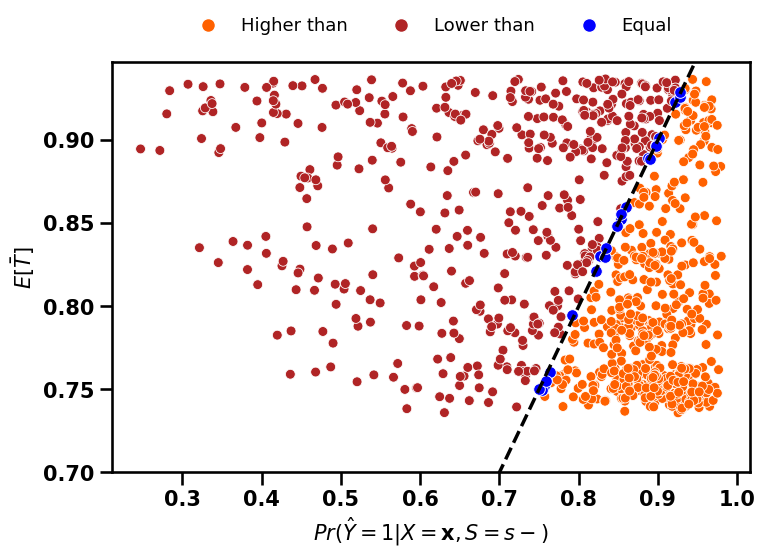

In [29]:
plot_df = sampler.plot_treatment_comparison(pr_y_means,double_sided_results)

#

# (6) Treatment categories

## 6.1 Extreme discrimination

Number of colored points: 307


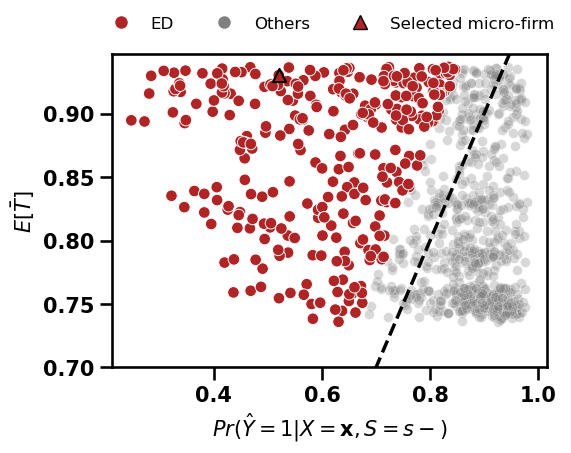

the data ratio is: 0.30486593843098314
#B02425 Protected Pr(Y=1) Mean: 0.6144681044235463, Standard Deviation: 0.14204805242684992
#B02425 Matched Mean Pr(Y=1) Mean: 0.8700090414618358, Standard Deviation: 0.05717974717428099


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


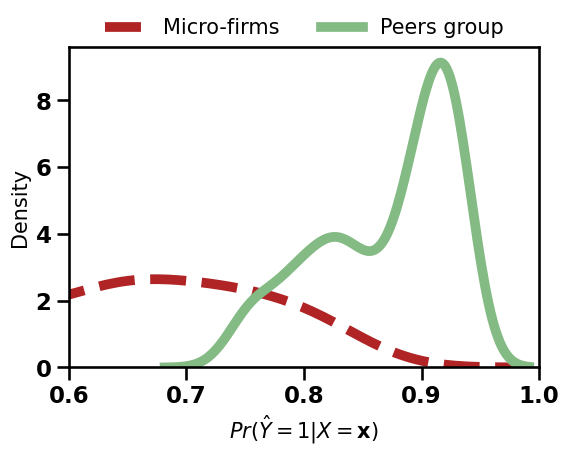

Kurtosis: -0.5130190866808846
Standard Deviation: 0.007080251186525488
Density Mean: 0.9303508960997193
Line Value (A): 0.5200970325508849


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


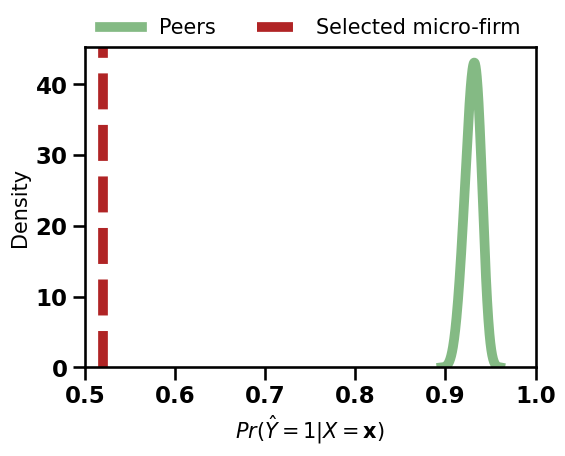

In [31]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter

treatment_threshold = 0.2 * protect_df['Pr(Y=1)'].std()

plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_greater_sided_results', comparison_type='less than')

single_greater_less_than_plot_df, single_greater_less_than_gray_df, single_greater_less_than_color_df = plotter.plot_scatter(pr_y_means, 0, single_greater_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_greater_less_than_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#B02425', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 0, show_line=True, line_color='#B02425', density_color='#84BA84')

In [32]:
line_1,b = plotter.try_2(single_greater_less_than_color_df,pr_y_means,label='single_greater_less than')

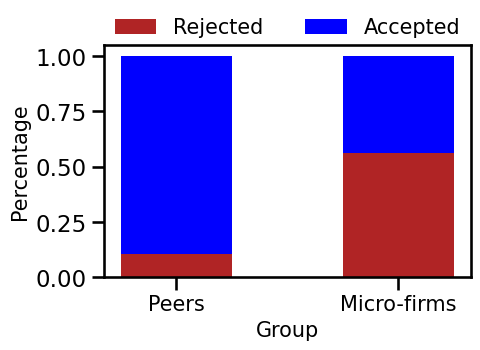

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,95645,0.103849
1,Nonprotect,1,825355,0.896151
2,Protect,0,173,0.563518
3,Protect,1,134,0.436482


In [33]:
single_greater_less_than_group_results = plotter.group_ground_truth(single_greater_less_than_color_df,label='single_greater_less than')
single_greater_less_than_group_results

## 6.2 Slight discrimination

Number of colored points: 151


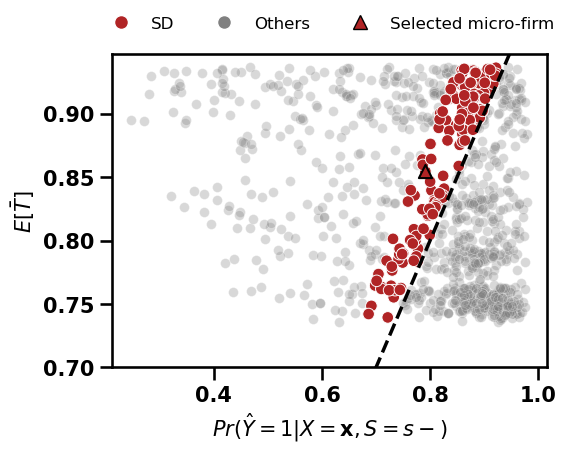

the data ratio is: 0.1499503475670308
#B02425 Protected Pr(Y=1) Mean: 0.8257525264957297, Standard Deviation: 0.06264735975254639
#B02425 Matched Mean Pr(Y=1) Mean: 0.8625930709746767, Standard Deviation: 0.05948124189650942


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


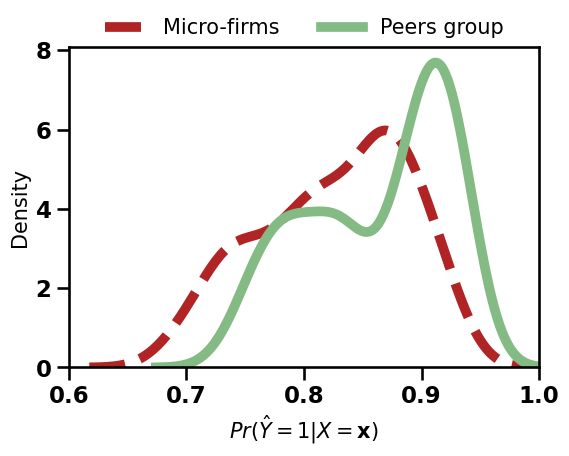

Kurtosis: -0.27154512245439966
Standard Deviation: 0.02041157488244822
Density Mean: 0.8546319340775193
Line Value (A): 0.7912948368150693


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


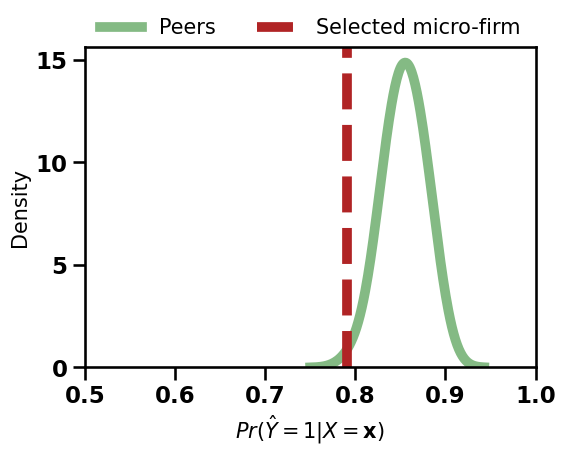

In [49]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter

plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_greater_sided_results', comparison_type='between')
single_greater_between_plot_df, single_greater_between_gray_df, single_greater_between_color_df = plotter.plot_scatter(pr_y_means, 16, single_greater_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_greater_between_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#B02425', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 16, show_line=True, line_color='#B02425', density_color='#84BA84')

In [35]:
line_2,b = plotter.try_2(single_greater_between_color_df,pr_y_means,label='single_greater_between')

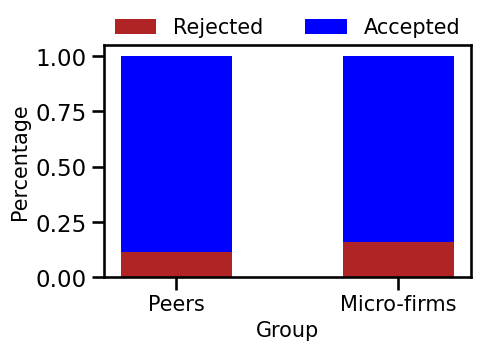

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,50456,0.111382
1,Nonprotect,1,402544,0.888618
2,Protect,0,24,0.158940
3,Protect,1,127,0.841060


In [36]:
single_greater_between_group_results = plotter.group_ground_truth(single_greater_between_color_df,label='single_greater_between')
single_greater_between_group_results

## 6.3 Fairly treated

Number of colored points: 22


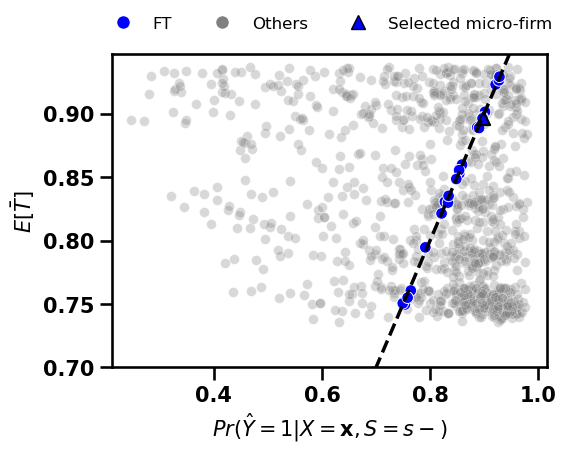

the data ratio is: 0.021847070506454815
blue Protected Pr(Y=1) Mean: 0.843452667183016, Standard Deviation: 0.06007554140831717
blue Matched Mean Pr(Y=1) Mean: 0.8430363048659864, Standard Deviation: 0.06091084930098429


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


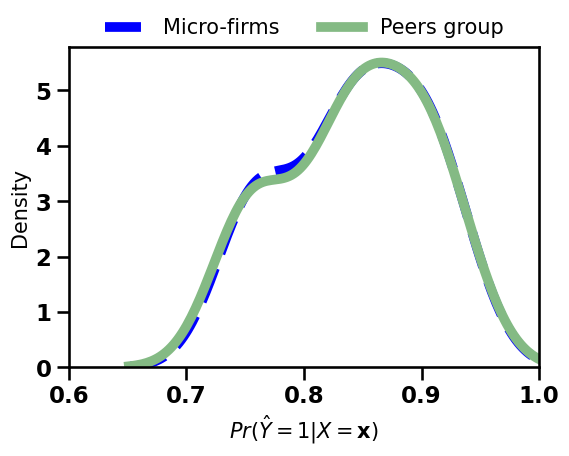

Kurtosis: -0.2847496181551876
Standard Deviation: 0.014494989170304989
Density Mean: 0.8962211444088201
Line Value (A): 0.8970961697438523


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


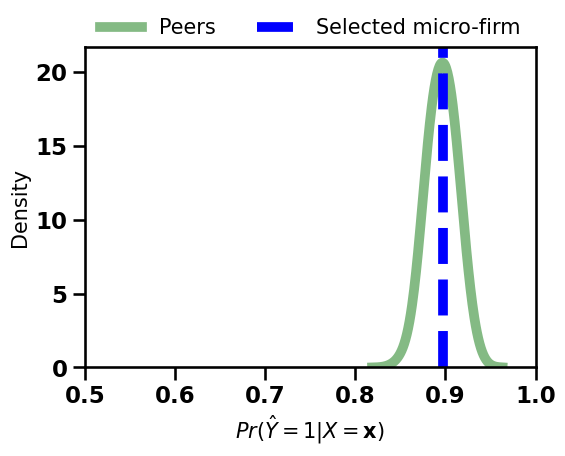

In [51]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter

plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='double_sided_results', comparison_type='less than')
double_fair_plot_df, double_fair_gray_df, double_fair_color_df = plotter.plot_scatter(pr_y_means, 1565, double_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(double_fair_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', 'blue', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 1565, show_line=True, line_color='blue', density_color='#84BA84')

In [38]:
line_3,b = plotter.try_2(double_fair_color_df,pr_y_means,label='double')

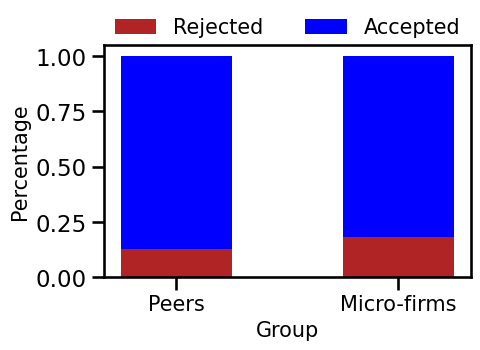

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,8262,0.125182
1,Nonprotect,1,57738,0.874818
2,Protect,0,4,0.181818
3,Protect,1,18,0.818182


In [39]:
double_fair_group_results = plotter.group_ground_truth(double_fair_color_df,label='double')
double_fair_group_results

## 6.4 Slight priviledge

Number of colored points: 224


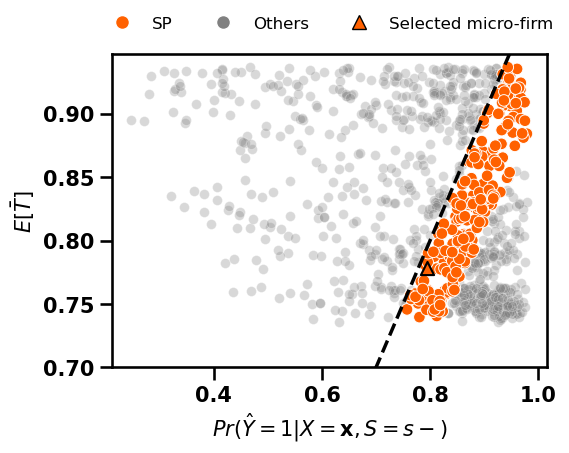

the data ratio is: 0.2224428997020854
#FF6100 Protected Pr(Y=1) Mean: 0.8771230745025392, Standard Deviation: 0.0549005521518458
#FF6100 Matched Mean Pr(Y=1) Mean: 0.8299152611081355, Standard Deviation: 0.05537311903376616


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


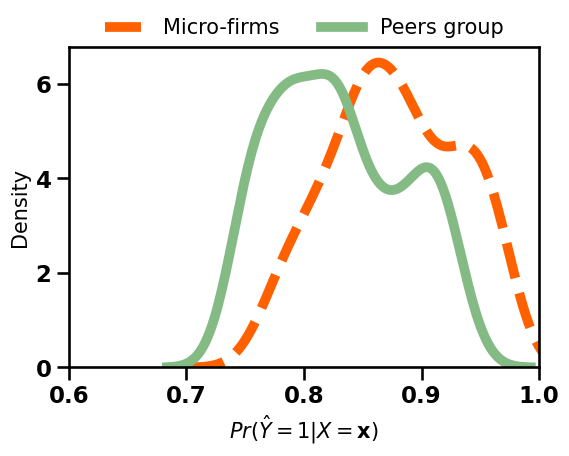

Kurtosis: 0.31139486738805733
Standard Deviation: 0.026893520939649338
Density Mean: 0.7783979151225594
Line Value (A): 0.7940037419239145


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


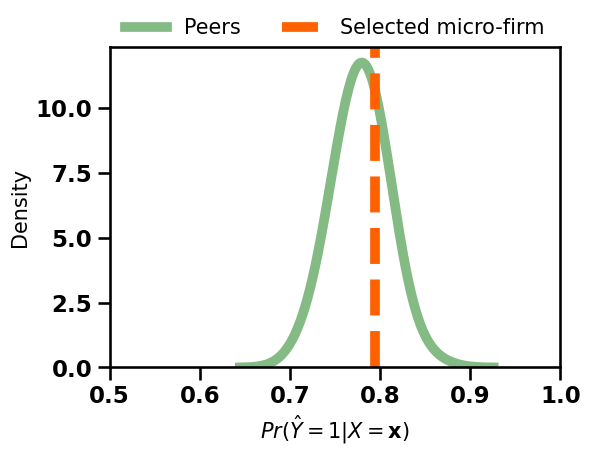

In [40]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter
plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_less_sided_results', comparison_type='between')
single_less_between_plot_df, single_less_between_gray_df, single_less_between_color_df = plotter.plot_scatter(pr_y_means, 88, single_less_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_less_between_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#FF6100', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 88, show_line=True, line_color='#FF6100', density_color='#84BA84')

In [41]:
line_4,b = plotter.try_2(single_less_between_color_df,pr_y_means,label='single_less_between')

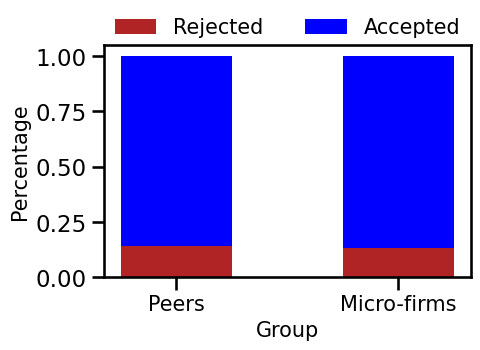

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,95064,0.141464
1,Nonprotect,1,576936,0.858536
2,Protect,0,29,0.129464
3,Protect,1,195,0.870536


In [42]:
single_less_between_group_results = plotter.group_ground_truth(single_less_between_color_df,label='single_less_between')
single_less_between_group_results

## 6.5 Extreme priviledge

Number of colored points: 303


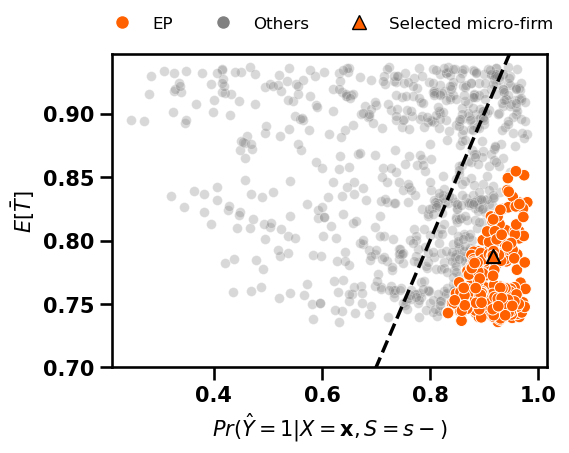

the data ratio is: 0.30089374379344586
#FF6100 Protected Pr(Y=1) Mean: 0.9133506129099728, Standard Deviation: 0.033915705617883804
#FF6100 Matched Mean Pr(Y=1) Mean: 0.7659453700688995, Standard Deviation: 0.02481652457228687


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:193: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data1, shade=False, color=color, linewidth=7, label='Micro-firms', linestyle='--')
C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:194: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data2, shade=False, color=density_color, linewidth=7, label='Peers group')


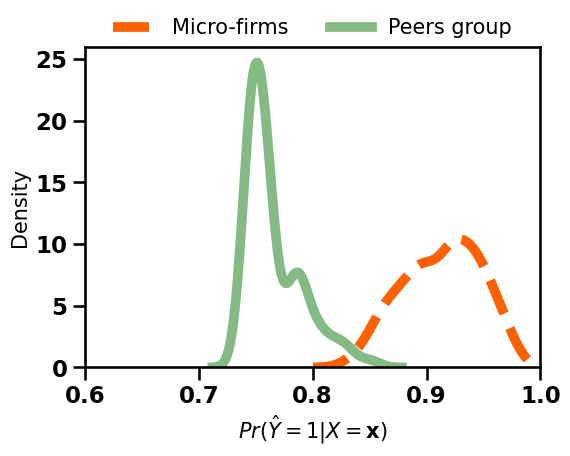

Kurtosis: -0.47392898592498556
Standard Deviation: 0.025513490346302358
Density Mean: 0.7880134705445697
Line Value (A): 0.9162897601249891


C:\Users\s2285280\fairness-credit-scoring\examples_model\size_rf_prediction\../..\analysis\extreme_analysis.py:637: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade=False, bw_adjust=bw_adjust, color=density_color, linewidth=7, label='Peers')


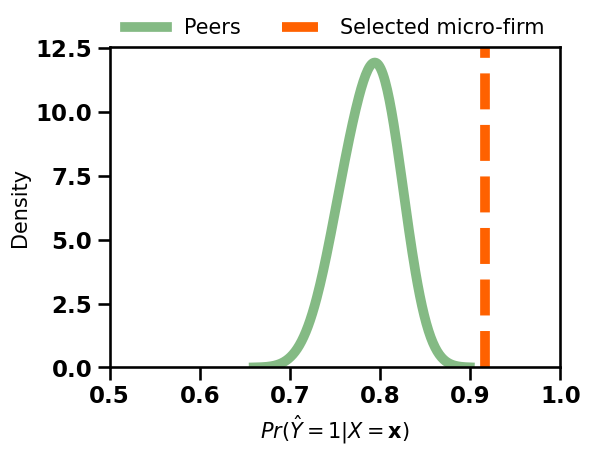

In [43]:
from analysis import extreme_analysis
from analysis.extreme_analysis import DensityScatterPlotter
plotter = DensityScatterPlotter(protect_df, nonprotect_df, bootstrapped_samples, result_type='single_less_sided_results', comparison_type='less than')
single_less_less_than_plot_df, single_less_less_than_gray_df, single_less_less_than_color_df = plotter.plot_scatter(pr_y_means, 1718, single_less_sided_results, threshold_type='floating', floating_ratio=0.1, mean_diff_threshold=treatment_threshold, p_value_threshold=0.05)

plotter.plot_group_density(single_less_less_than_color_df, 'protected Pr(Y=1)', 'matched mean Pr(Y=1)', '#FF6100', density_color='#84BA84')
plotter.plot_case_density(protect_df,pr_y_means, 1718, show_line=True, line_color='#FF6100', density_color='#84BA84')

In [44]:
line_5, b = plotter.try_2(single_less_less_than_color_df,pr_y_means,label='single_less_less than')

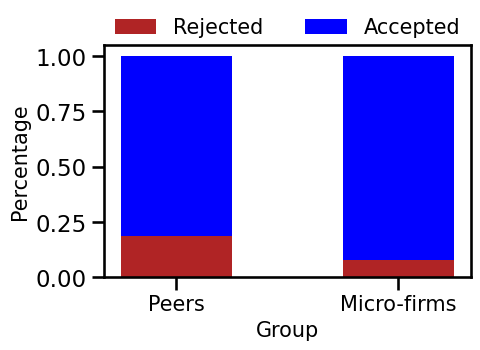

,Type,Binary Y,Count,Proportion
0,Nonprotect,0,170257,0.187301
1,Nonprotect,1,738743,0.812699
2,Protect,0,23,0.075908
3,Protect,1,280,0.924092


In [45]:
single_less_less_than_group_results = plotter.group_ground_truth(single_less_less_than_color_df,label='single_less_less than')
single_less_less_than_group_results

#

# (7) Validation of peer-induced framework

Difference for ED: 0.45966883821932686
Difference for FT: 0.05663636363636365
Difference for EP: -0.11139383938393838


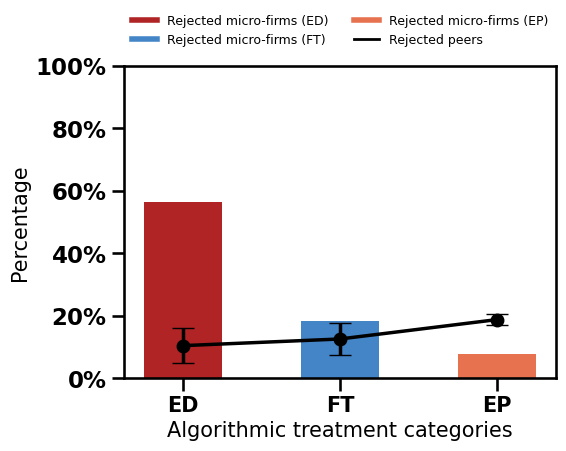

In [46]:
from analysis import outcomes_in_discrimination
from analysis.outcomes_in_discrimination import DiscriminationBarChart

dfs = [
    single_greater_less_than_group_results,
    double_fair_group_results,
    single_less_less_than_group_results
]


lines=[line_1,line_3,line_5]
plotter = DiscriminationBarChart(dfs, lines)
outcomes_in_discrimination_df = plotter.extract_data()
plotter.plot_stacked_bar_chart()

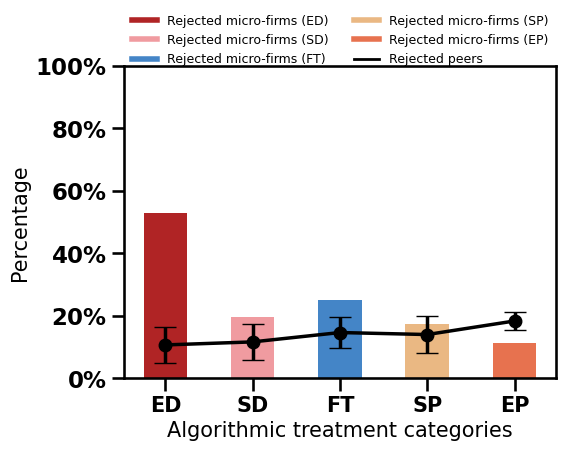

In [421]:
from analysis import outcomes_in_discrimination
from analysis.outcomes_in_discrimination import DiscriminationBarChart

dfs = [
    single_greater_less_than_group_results,
    single_greater_between_group_results,
    double_fair_group_results,
    single_less_between_group_results,
    single_less_less_than_group_results
]


lines=[line_1,line_2,line_3,line_4,line_5]
plotter = DiscriminationBarChart(dfs, lines)
outcomes_in_discrimination_df = plotter.extract_data()
plotter.plot_stacked_bar_chart()